## Задание X

In [6]:
# импортируем модули
import matplotlib.pyplot as plt
import numpy as np
# размер фигуры matplotlib по-умолчанию
plt.rcParams['figure.figsize'] = [13, 8]

### Загружаем трейсы

In [3]:
textin = np.load('traces/textin.npy')
textout = np.load('traces/textout.npy')
traces = np.load('traces/traces.npy')

In [4]:
ntraces = np.shape(traces)[0] - 1
nsamples = np.shape(traces)[1]

Рисуем несколько, чтобы проверить выравнивание:

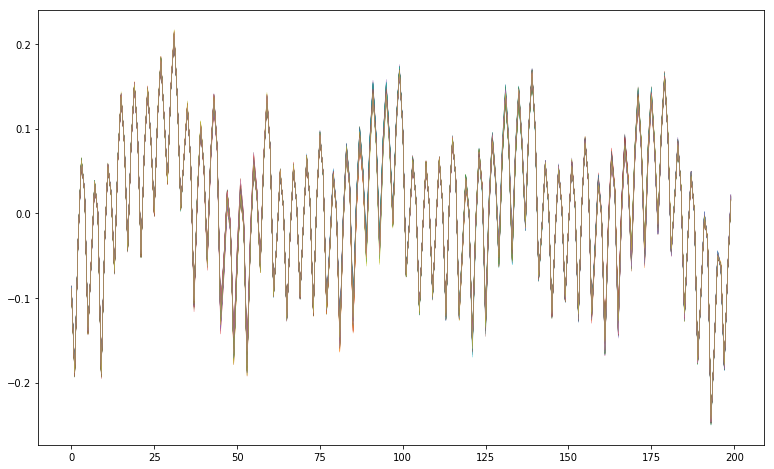

In [10]:
start = 900
end = 1100
for i in range(ntraces):
    plt.plot(traces[i][start:end], linewidth=.3)

### CPA

Определим нашу модель: первый раунд AES после операции подстановки (SubBytes)

In [12]:
# Hemming Weight
hw = [bin(n).count("1") for n in range(0,256)]

# AES SBox
sbox = (
0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16)

# Leakage function
def leakage(data, key_guess):
    return hw[sbox[data ^ key_guess]]

**TODO: написать имлементацию корреляции замеров из трейсов в каждый момент времени с hypothesis**: наша гипотеза как выглядел бы график потребления питания при данном ключе. Должна возвращать максимальный коэффициент корреляции. Можете использовать:
* https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.corrcoef.html

In [14]:
def fast_correlation(hypothesis):
    sumnum = np.zeros(nsamples)
    sumden1 = np.zeros(nsamples)
    sumden2 = np.zeros(nsamples)
    # mean of hypothesis
    meanh = np.mean(hypothesis, dtype=np.float64)
    # mean of all points in trace
    meant = np.mean(traces, axis=0, dtype=np.float64)

    # for each trace, do the following
    for tnum in range(0, ntraces):
        hdiff = (hypothesis[tnum] - meanh)
        tdiff = traces[tnum, : ] - meant
        sumnum = sumnum + (hdiff * tdiff)
        sumden1 = sumden1 + hdiff * hdiff 
        sumden2 = sumden2 + tdiff * tdiff

    correlation = max(abs(sumnum / np.sqrt( sumden1 * sumden2 )))
    return correlation

CPA атака:

In [15]:
def key_guesses_text(coefs, n=3):
    best_guesses = np.argsort(coefs)[::-1][:n]
    desc = []
    tmpl = "key guess: %02x (%06f)" 
    for guess in np.nditer(best_guesses):
        desc.insert(0, tmpl % (guess, coefs[guess]))
    return ", ".join(desc)

key = np.zeros(16)
# for each key byte
for key_byte_num in range(16):
    maxcpa = np.zeros(256)
    # for each key guess at key_byte_num place
    for key_guess in range(0, 256):
        # calculate leakage for data on each trace
        hyp = np.zeros(ntraces)
        for tnum in range(ntraces):
            hyp[tnum] = leakage(textin[tnum][key_byte_num], key_guess)
        corr = correlation(hyp)
        maxcpa[key_guess] = corr
    key[key_byte_num] = np.argmax(maxcpa)
    print("Position #%02d: %s" % (key_byte_num, key_guesses_text(maxcpa)))

RuntimeError: Not implemented

**TODO: написать функцию проверки найденного ключа: сделать операцию шифрования и сравнить полученный шифротекст с шифротекстом из файла.** Можете использовать:
* https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.astype.html
* https://www.pycryptodome.org/en/latest/src/cipher/aes.html

In [17]:
from Crypto.Cipher import AES
raise RuntimeError("Not implemented")

RuntimeError: Not implemented